In [1]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

import sys
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "../..")))

In [2]:
path = os.path.abspath(os.path.join(os.getcwd(), "../../data/raw/SCLabels_v1.0.0"))

data = {
    "train": {
        "images": [],
        "ground_truth": [],
        "predicted_mask": []
    },
    "validation": {
        "images": [],
        "ground_truth": [],
        "predicted_mask": []
    },
    "test": {
        "images": [],
        "ground_truth": [],
        "predicted_mask": []
    }
}

# Open the image file
base_path = os.path.abspath(os.path.join(os.getcwd(), "../../data/SCLabels_prediction_by_set_unet/"))

# data_dirs = ["images", "mask", "predicted_mask"]
sub_dirs = ["train", "validation", "test"]

for sub_dir in sub_dirs:
    for file in os.listdir(os.path.join(base_path, "images", sub_dir)):
        if file.endswith(".jpg"):
            path = os.path.join(base_path, "images", sub_dir, file)
            data[sub_dir]["images"].append(path)

            file = file.replace("image.jpg", "mask.png")
            path = os.path.join(base_path, "mask", sub_dir, file)
            data[sub_dir]["ground_truth"].append(path)

            file = file.replace("mask.png", "pred.png")
            path = os.path.join(base_path, "predicted_mask", sub_dir, file)
            data[sub_dir]["predicted_mask"].append(path)

In [5]:
# Function to transform the mask to a binary mask
from scipy.ndimage import distance_transform_edt

def fill_no_data(pred, no_data=0):
    no_data_pred = (pred == no_data)
    _, indices = distance_transform_edt(no_data_pred, return_indices=True)
    nearest_x, nearest_y = indices
    filled_pred = pred.copy()
    filled_pred[no_data_pred] = pred[nearest_x[no_data_pred], nearest_y[no_data_pred]]
    return filled_pred

def transform_to_binary(mask, value):
    mask = np.where(mask == value, 1, 0).astype(np.uint8)
    return mask

def get_contours(mask):
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    return contours

def draw_contours(img, contours):
    img = cv2.drawContours(img, contours, -1, (255, 255, 255), 1)
    return img

# Filter contours that are too close to the border
def filter_border_contours(mask, contours, margin_threshold=2):
    height, width = mask.shape

    filtered_contours = []

    for cnt in contours:
        new_cnt = []
        for point in cnt:
            x, y = point[0]

            # In case that the contour is too close to the border, we set it to -1 or width/height + 1
            if (x < margin_threshold):
                x = -1
            if (y < margin_threshold):
                y = -1
            if (x > width - margin_threshold):
                x = width + 1
            if (y > height - margin_threshold):
                y = height + 1
            
            new_cnt.append([[x, y]])
            
        if len(new_cnt) > 0:  # Només afegim si encara hi ha punts
            filtered_contours.append(np.array(new_cnt))
    
    # return filtered_contours
    return filtered_contours

def transform_mask_to_shoreline(pred_path, no_data=0, landward=75):
    pred = cv2.imread(pred_path, cv2.IMREAD_GRAYSCALE)

    filled_pred = fill_no_data(pred, no_data)
    filled_pred = transform_to_binary(filled_pred, landward)
    contours = get_contours(filled_pred)

    shoreline = np.zeros_like(filled_pred)
    contours = filter_border_contours(filled_pred, contours)
    # print(contours)
    shoreline = draw_contours(shoreline, contours)
    
    return shoreline, contours

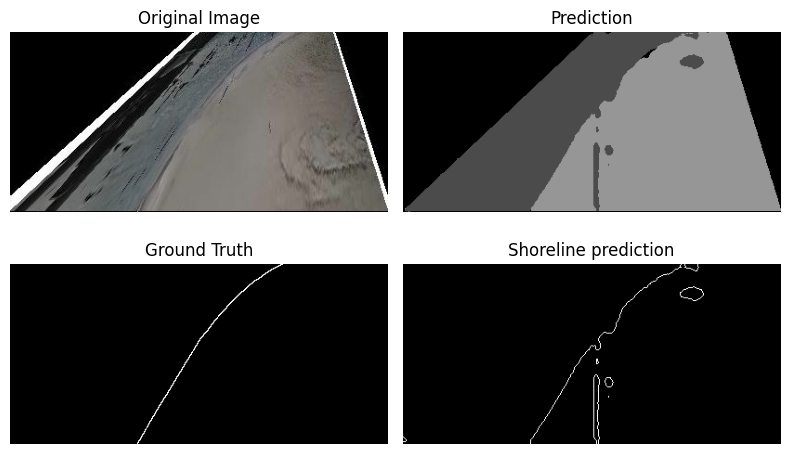

In [155]:
index = 4
img = data["test"]["images"][index]
ground_truth = data["test"]["ground_truth"][index]
pred_path = data["test"]["predicted_mask"][index]

img = cv2.imread(img)
ground_truth = cv2.imread(ground_truth, cv2.IMREAD_GRAYSCALE)
ground_truth = transform_to_binary(ground_truth, 255)*255

pred, contours = transform_mask_to_shoreline(pred_path = pred_path)

ground_truth = cv2.cvtColor(ground_truth, cv2.COLOR_GRAY2RGB)

# plt.imshow(ground_truth)
# plt.show()

# transform ground turth to rgb
# img = draw_contours(ground_truth, contours)
# create aux img size of
aux_img = np.zeros_like(img)
aux_img = draw_contours(aux_img, contours)

fig, axes = plt.subplots(2, 2, figsize=(8, 5))


# Mostra cada imatge en un subplot
axes[0][0].imshow(img)
axes[0][0].set_title("Original Image")
axes[0][0].axis("off")

axes[0][1].imshow(cv2.imread(pred_path), cmap="gray")
axes[0][1].set_title("Prediction")
axes[0][1].axis("off")

axes[1][0].imshow(ground_truth)
axes[1][0].set_title("Ground Truth")
axes[1][0].axis("off")

axes[1][1].imshow(aux_img)
axes[1][1].set_title("Shoreline prediction")
axes[1][1].axis("off")

plt.tight_layout()
plt.show()

In [8]:
def chamfer_distance(pred, ground_truth):
    dist_transform = distance_transform_edt(1 - ground_truth)
    distances = dist_transform[pred > 0]
    mean_distance = np.mean(distances)

    return mean_distance

def compute_chamfer_distance(data_set):

    global_distance = []

    for index in range(len(data_set["images"])):
        img_path = data_set["images"][index]
        ground_truth_path = data_set["ground_truth"][index]
        pred_path = data_set["predicted_mask"][index]

        img = cv2.imread(img_path)
        ground_truth = cv2.imread(ground_truth_path, cv2.IMREAD_GRAYSCALE)
        ground_truth = transform_to_binary(ground_truth, 255)

        pred, contours = transform_mask_to_shoreline(pred_path)

        distance = chamfer_distance(pred, ground_truth)
        global_distance.append(distance)
    
    print("Mean distance: ", np.mean(global_distance))
    print("Std distance: ", np.std(global_distance))
    print("Max distance: ", np.max(global_distance))
    print("Min distance: ", np.min(global_distance))

In [ ]:

print("Train set")
compute_chamfer_distance(data["train"])

print("\nValidation set")
compute_chamfer_distance(data["validation"])

print("\nTest set")
compute_chamfer_distance(data["test"])

# Test 2, with fors

In [13]:
def find_shoreline(pred, land_pixel, sea_pixel):
    shoreline = np.zeros_like(pred)
    for i in range(pred.shape[0]):
        for j in range(1, pred.shape[1]):
            if pred[i, j] == land_pixel and pred[i, j-1] == sea_pixel:
                shoreline[i, j] = 1
            if pred[i, j] == sea_pixel and pred[i, j-1] == land_pixel:
                shoreline[i, j-1] = 1

    for j in range(pred.shape[1]):
        for i in range(1, pred.shape[0]):
            if pred[i, j] == land_pixel and pred[i-1, j] == sea_pixel:
                shoreline[i, j] = 1
            if pred[i, j] == sea_pixel and pred[i-1, j] == land_pixel:
                shoreline[i-1, j] = 1
            
    return shoreline

def find_largest_contour(shoreline_mask):
    # Trobar els contorns a la màscara de la línia de costa
    contours, _ = cv2.findContours(shoreline_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Trobar el contorn més gran
    largest_contour = max(contours, key=len)

    return largest_contour

def transform_mask_to_shoreline2(pred_path, no_data=0, landward=75, seaward=150):
    pred = cv2.imread(pred_path, cv2.IMREAD_GRAYSCALE)

    shoreline = find_shoreline(pred, landward, seaward)

    largest_contour = find_largest_contour(shoreline)

    # Crear una màscara per dibuixar el contorn més gran
    largest_shoreline = np.zeros_like(shoreline)
    cv2.drawContours(largest_shoreline, [largest_contour], -1, 1, thickness=cv2.FILLED)

    return largest_shoreline

    # return shoreline

0.23300970873786409


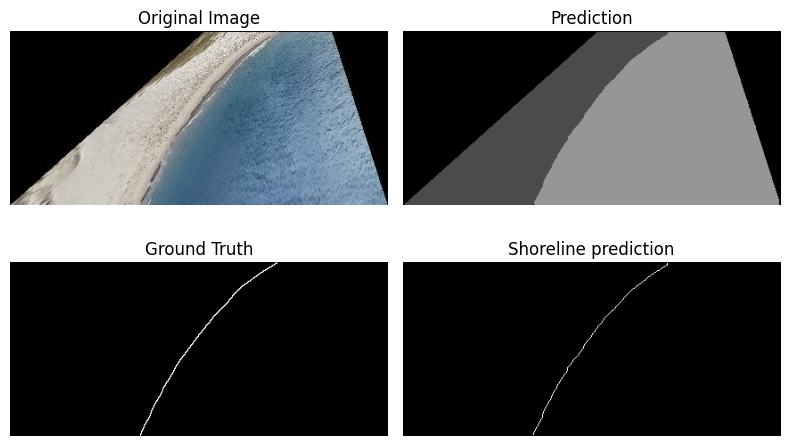

In [33]:
index = 102 # 85 # 160
img = data["test"]["images"][index]
ground_truth = data["test"]["ground_truth"][index]
pred_path = data["test"]["predicted_mask"][index]

img = cv2.imread(img)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
ground_truth = cv2.imread(ground_truth, cv2.IMREAD_GRAYSCALE)
ground_truth = transform_to_binary(ground_truth, 255)

pred = transform_mask_to_shoreline2(pred_path = pred_path)
# ground_truth = cv2.cvtColor(ground_truth, cv2.COLOR_GRAY2RGB)
print(chamfer_distance(pred, ground_truth))

# aux_img = np.zeros_like(img)
# aux_img = draw_contours(aux_img, contours)

fig, axes = plt.subplots(2, 2, figsize=(8, 5))


# Mostra cada imatge en un subplot
axes[0][0].imshow(img)
axes[0][0].set_title("Original Image")
axes[0][0].axis("off")

axes[0][1].imshow(cv2.imread(pred_path), cmap="gray")
axes[0][1].set_title("Prediction")
axes[0][1].axis("off")

axes[1][0].imshow(ground_truth, cmap="gray")
axes[1][0].set_title("Ground Truth")
axes[1][0].axis("off")

axes[1][1].imshow(pred, cmap="gray")
axes[1][1].set_title("Shoreline prediction")
axes[1][1].axis("off")

plt.tight_layout()
plt.show()


In [11]:
def chamfer_distance(pred, ground_truth):
    dist_transform = distance_transform_edt(1 - ground_truth)
    distances = dist_transform[pred > 0]
    mean_distance = np.mean(distances)

    return mean_distance


In [32]:
def compute_chamfer_distance(data_set):

    coasts = ["agrelo", "cies", "cadiz", "samarador", "arenaldentem"]
    global_distance = {
        "agrelo": [],
        "cies": [],
        "cadiz": [],
        "samarador": [],
        "arenaldentem": []
    }

    min_distance = 1000
    min_img = ""
    min_index = 0

    for index in range(len(data_set["images"])):
        # print(data_set["images"][index])
        img_path = data_set["images"][index]
        ground_truth_path = data_set["ground_truth"][index]
        pred_path = data_set["predicted_mask"][index]

        img = cv2.imread(img_path)
        ground_truth = cv2.imread(ground_truth_path, cv2.IMREAD_GRAYSCALE)
        ground_truth = transform_to_binary(ground_truth, 255)

        pred = transform_mask_to_shoreline2(pred_path)

        distance = chamfer_distance(pred, ground_truth)

        for coast in coasts:
            if coast in img_path:
                global_distance[coast].append(distance)

        if distance < min_distance:
            min_distance = distance
            min_img = img_path
            min_index = index

        # distance = chamfer_distance(pred, ground_truth)
        # global_distance.append(distance)
        # print(index, distance, data_set["images"][index])
    
    # print("Mean distance: ", np.mean(global_distance))
    # print("Std distance: ", np.std(global_distance))
    # print("Max distance: ", np.max(global_distance))
    # print("Min distance: ", np.min(global_distance))

    for coast in coasts:
        print(f"\n{coast} - {len(global_distance[coast])} images")
        print("Mean distance: ", np.mean(global_distance[coast]))
        print("Std distance: ", np.std(global_distance[coast]))
        print("Max distance: ", np.max(global_distance[coast]))
        print("Min distance: ", np.min(global_distance[coast]))

    print(min_distance, min_img, min_index)

# print("Train set")
# compute_chamfer_distance(data["train"])

# print("\nValidation set")
# compute_chamfer_distance(data["validation"])

print("\nTest set")
compute_chamfer_distance(data["test"])


Test set

agrelo - 25 images
Mean distance:  12.973532090101832
Std distance:  21.178524992478422
Max distance:  96.91931337583343
Min distance:  0.7801564005467394

cies - 44 images
Mean distance:  2.3749816006309388
Std distance:  5.856054464401343
Max distance:  39.746536171905156
Min distance:  0.23300970873786409

cadiz - 95 images
Mean distance:  13.831805511747445
Std distance:  21.863973332499576
Max distance:  196.09249735733087
Min distance:  1.6582403675691686

samarador - 6 images
Mean distance:  44.86224086799436
Std distance:  39.26432591342707
Max distance:  98.13468763368192
Min distance:  4.128946245097757

arenaldentem - 4 images
Mean distance:  12.117424275835699
Std distance:  5.472471226974036
Max distance:  17.300956875700894
Min distance:  3.97767652916938
0.23300970873786409 c:\Users\josep\Documents\SOCIB\Shoreline-extraction\data\SCLabels_prediction_by_set_unet\images\test\1632909600.Wed.Sep.29_11_00_00.CET.2021.cies.image.jpg 102
